In [1]:
import streamlit
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta

In [2]:
stock_obj = yf.Ticker('0050.TW')
start = datetime.date(2005, 1, 10)
# end = datetime.date(, last_month, last_day)
end = datetime.date.today()
stock_df = stock_obj.history(start=start, end=end, auto_adjust=False)

In [3]:
start, end

(datetime.date(2005, 1, 10), datetime.date(2021, 3, 9))

In [4]:
def month_range_day(start=None, end=None):
    month_range = pd.date_range(start=start, end=end, freq='M')
    month_day = month_range.day.values
    month_day[start.day < month_day] = start.day
    return pd.to_datetime(month_range.year*10000+month_range.month*100+month_day, format='%Y%m%d')

In [5]:
stock_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

In [6]:
installment = 3000
investment_dates_all = month_range_day(start, end)
offset_month=1
investment_dates_all = investment_dates_all + pd.tseries.offsets.DateOffset(days=offset_month-1)
investment_dates_all
investment_dates = investment_dates_all[(investment_dates_all < stock_df.index[-1]) & (investment_dates_all > stock_df.index[0])]
print(investment_dates)
closest_investment_dates = stock_df.index.searchsorted(investment_dates)

units_purchased = installment / stock_df['Open'][closest_investment_dates]
units_purchased

DatetimeIndex(['2008-01-10', '2008-02-10', '2008-03-10', '2008-04-10',
               '2008-05-10', '2008-06-10', '2008-07-10', '2008-08-10',
               '2008-09-10', '2008-10-10',
               ...
               '2020-05-10', '2020-06-10', '2020-07-10', '2020-08-10',
               '2020-09-10', '2020-10-10', '2020-11-10', '2020-12-10',
               '2021-01-10', '2021-02-10'],
              dtype='datetime64[ns]', length=158, freq=None)


Date
2008-01-10    52.038160
2008-02-12    54.595086
2008-03-10    50.403225
2008-04-10    47.725103
2008-05-12    47.976972
                ...    
2020-10-12    28.116214
2020-11-10    27.777778
2020-12-10    25.178346
2021-01-11    22.865854
2021-02-17    21.582734
Name: Open, Length: 158, dtype: float64

In [11]:
purchase_list = np.zeros(len(stock_df.index))
purchase_list[closest_investment_dates] = units_purchased
# print((purchase_list != 0).sum())
total_purchase_list = np.cumsum(purchase_list)
total_purchase_value = np.multiply(total_purchase_list, stock_df['Open'])
total_purchase_value.head(10)

investment_dates = closest_investment_dates

# investment_dates, units_purchased = doSIP(SIPAMOUNT, '2010-02-01', '2016-02-01', 7)
lumpsum_amount = len(units_purchased) * installment
purchase_list = np.zeros(len(stock_df.index))
purchase_list[investment_dates] = units_purchased
total_purchase_list = np.cumsum(purchase_list)
total_purchase_value = np.multiply(total_purchase_list, stock_df['Open'])

In [57]:
stock_df['Open'][investment_dates[0]:] / stock_df['Open'][investment_dates[0]] * lumpsum_amount

Date
2008-02-01    4.740000e+05
2008-02-12    4.648635e+05
2008-02-13    4.664708e+05
2008-02-14    4.866896e+05
2008-02-15    4.860975e+05
                  ...     
2021-03-02    1.146297e+06
2021-03-03    1.131492e+06
2021-03-04    1.136568e+06
2021-03-05    1.100191e+06
2021-03-08    1.131492e+06
Name: Open, Length: 3219, dtype: float64

In [58]:
lumpsum_amount / stock_df['Open'][investment_dates[0]] * stock_df['Open'][investment_dates[0]:][-1]

1131492.0824775286

In [69]:
stock_daily_returns = stock_df['Adj Close'][investment_dates[0]:].ffill().pct_change()
stock_daily_returns

Date
2008-01-09         NaN
2008-01-10   -0.009450
2008-01-11   -0.003122
2008-01-14    0.017226
2008-01-15    0.030961
                ...   
2021-03-02    0.000375
2021-03-03    0.014612
2021-03-04   -0.019572
2021-03-05   -0.006026
2021-03-08   -0.000758
Name: Adj Close, Length: 3236, dtype: float64

### 一次投資全部

In [124]:
# stock_obj = yf.Ticker(stock_id)
# stock_monthly_returns = stock_df['Adj Close'].resample(
#     'M').ffill().pct_change()
stock_daily_returns = stock_df['Adj Close'][investment_dates[0]:].ffill().pct_change()
start = stock_daily_returns.index[0]
end = stock_df.index[-1] 
year_diff = relativedelta(end, start).years + \
    (relativedelta(end, start).months)/12

init_balance = balance = lumpsum_amount
print(lumpsum_amount)
total_balance = stock_daily_returns.copy()
total_balance[0] = 0

for i in range(len(stock_daily_returns)):
    balance = balance * (1+total_balance[i])
    total_balance[i] = balance

daily_returns = stock_daily_returns * 100
growth = pd.concat([daily_returns.rename("Return (%)"),
                    total_balance.rename("Balance")], axis=1)

returnRate = (total_balance[-1] - total_balance[0])/total_balance[0]
cgar = (((1+returnRate)**(1/year_diff))-1)
total_balance[-1]

474000


1084074.6095212447

### 定期定額

In [97]:
stock_daily_returns = stock_df['Adj Close'][investment_dates[0]:].ffill().pct_change()

In [103]:
stock_daily_returns

Date
2008-01-10         NaN
2008-01-11   -0.003122
2008-01-14    0.017226
2008-01-15    0.030961
2008-01-16   -0.032520
                ...   
2021-03-02    0.000375
2021-03-03    0.014612
2021-03-04   -0.019572
2021-03-05   -0.006026
2021-03-08   -0.000758
Name: Adj Close, Length: 3235, dtype: float64

In [122]:
stock_daily_returns = stock_df['Adj Close'][investment_dates[0]:].ffill().pct_change()
# print(stock_daily_returns)
start = stock_daily_returns.index[0]
end = stock_df.index[-1] 
# print(end)
year_diff = relativedelta(end, start).years + \
    (relativedelta(end, start).months)/12

installment = 3000
init_balance = balance = installment
total_balance = stock_daily_returns.copy()
total_balance[0] = 0

j = 0 # for investment_dates
j_investment_dates = investment_dates - investment_dates[0]
for i in range(len(stock_daily_returns)):
    balance = balance * (1+total_balance[i])
    if i == j_investment_dates[j] and i != 0:
        j += 1
        if (j >= len(j_investment_dates)):
            j = len(j_investment_dates) - 1
        else:
            balance += installment
    elif i == 0:
        j += 1
    total_balance[i] = balance

daily_returns = stock_daily_returns * 100
growth = pd.concat([daily_returns.rename("Return (%)"),
                    total_balance.rename("Balance")], axis=1)
# print(len(investment_dates) * installment)
returnRate = (total_balance[-1] - lumpsum_amount)/lumpsum_amount
cgar = (((1+returnRate)**(1/year_diff))-1)
total_balance[-1]

[   0   17   35   57   78   99  121  142  164  185  205  227  249  263
  283  305  325  345  367  388  411  433  454  476  497  519  532  554
  574  597  618  639  662  682  704  726  747  764  783  803  823  845
  866  888  911  930  952  974  995 1011 1030 1050 1071 1093 1114 1137
 1158 1180 1202 1222 1243 1263 1277 1297 1318 1339 1360 1383 1403 1423
 1444 1465 1487 1502 1521 1543 1564 1584 1606 1628 1649 1671 1691 1713
 1734 1755 1768 1789 1809 1831 1852 1873 1896 1916 1937 1959 1980 1999
 2016 2036 2056 2079 2099 2121 2144 2163 2185 2207 2227 2244 2263 2282
 2303 2324 2344 2367 2389 2408 2430 2451 2472 2495 2508 2526 2547 2569
 2589 2612 2633 2654 2676 2696 2717 2732 2750 2770 2791 2811 2833 2855
 2875 2895 2915 2936 2958 2972 2992 3013 3033 3055 3075 3096 3119 3138
 3159 3181 3202 3222]


1000211.9874329868

In [120]:
total_purchase_value[-1]

1017427.8376922536

In [55]:
lumpsum_amount

474000

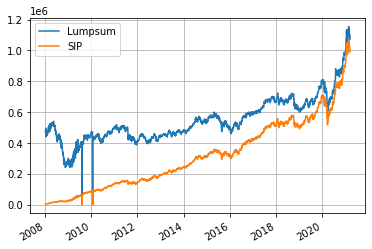

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1)
ax.plot(stock_df.index[investment_dates[0]:],
        stock_df['Open'][investment_dates[0]:] / stock_df['Open'][investment_dates[0]] * lumpsum_amount,
        label='Lumpsum')
ax.plot(stock_df.index[closest_investment_dates[0]:], total_purchase_value[closest_investment_dates[0]:], label='SIP')
ax.grid(True)
ax.legend()
fig.autofmt_xdate()
plt.show()

1017427.8376922536


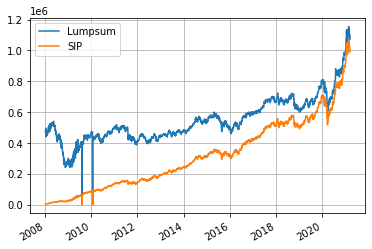

In [106]:
from matplotlib import pyplot as plt
import streamlit
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta


# def _month_range_day(start=None, end=None):
#     month_range = pd.date_range(start=start, end=end, freq='M')
#     month_day = month_range.day.values
#     month_day[start.day < month_day] = start.day
#     return pd.to_datetime(month_range.year*10000+month_range.month*100+month_day, format='%Y%m%d')

def _month_range_day(installment, stock_df, start=None, end=None, offset=1):
    investment_dates_all = pd.date_range(start, end, freq='MS')
    investment_dates_all = investment_dates_all + \
        pd.tseries.offsets.DateOffset(days=offset-1)
    investment_dates = investment_dates_all[(investment_dates_all < stock_df.index[-1]) & (investment_dates_all > stock_df.index[0])]
    closest_investment_dates = stock_df.index.searchsorted(investment_dates)
    units_purchased = installment / \
        stock_df['Open'][closest_investment_dates]
    return closest_investment_dates, units_purchased


stock_obj = yf.Ticker('0050.TW')
start = datetime.date(2005, 1, 1)
end = datetime.date.today()
stock_df = stock_obj.history(start=start, end=end, auto_adjust=False)

installment = 3000

investment_dates, units_purchased = _month_range_day(installment, stock_df, start, end, offset=10)

purchase_list = np.zeros(len(stock_df.index))
purchase_list[investment_dates] = units_purchased
total_purchase_list = np.cumsum(purchase_list)
total_purchase_value = np.multiply(total_purchase_list, stock_df['Open'])
print(total_purchase_value[-1])

lumpsum_amount = len(units_purchased) * installment
purchase_list = np.zeros(len(stock_df.index))
purchase_list[investment_dates] = units_purchased
total_purchase_list = np.cumsum(purchase_list)
total_purchase_value = np.multiply(total_purchase_list, stock_df['Open'])


fig, ax = plt.subplots(1)
ax.plot(stock_df.index[investment_dates[0]:],
        stock_df['Open'][investment_dates[0]:] /
        stock_df['Open'][investment_dates[0]] * lumpsum_amount,
        label='Lumpsum')
ax.plot(stock_df.index[investment_dates[0]:],
        total_purchase_value[investment_dates[0]:], label='SIP')
ax.grid(True)
ax.legend()
fig.autofmt_xdate()
plt.show()


In [137]:
stock_df.index[investment_dates]

DatetimeIndex(['2008-01-10', '2008-02-12', '2008-03-10', '2008-04-10',
               '2008-05-12', '2008-06-10', '2008-07-10', '2008-08-11',
               '2008-09-10', '2008-10-13',
               ...
               '2020-05-11', '2020-06-10', '2020-07-10', '2020-08-10',
               '2020-09-10', '2020-10-12', '2020-11-10', '2020-12-10',
               '2021-01-11', '2021-02-17'],
              dtype='datetime64[ns]', name='Date', length=158, freq=None)

In [144]:
cost_df = pd.DataFrame()
installment = 3000
for i in range(len(investment_dates)):
    cost_df = cost_df.append({'Cost': (i + 1) * installment}, ignore_index=True)
cost_df.index = stock_df.index[investment_dates]
cost_df

,Cost
Date,
2008-01-10,3000.0
2008-02-12,6000.0
2008-03-10,9000.0
2008-04-10,12000.0
2008-05-12,15000.0
...,...
2020-10-12,462000.0
2020-11-10,465000.0
2020-12-10,468000.0


In [126]:
purchased_agg = units_purchased.copy()
for i in range(1, len(purchased_agg)):
    purchased_agg[i] += purchased_agg[i - 1]
purchased_agg

Date
2008-01-10      52.038160
2008-02-12     106.633246
2008-03-10     157.036471
2008-04-10     204.761574
2008-05-12     252.738546
                 ...     
2020-10-12    7509.532392
2020-11-10    7537.310170
2020-12-10    7562.488516
2021-01-11    7585.354370
2021-02-17    7606.937104
Name: Open, Length: 158, dtype: float64

In [60]:
stock_df.index[investment_dates[0]:],stock_df['Open'][investment_dates[0]:] / stock_df['Open'][investment_dates[0]] * lumpsum_amount,

(DatetimeIndex(['2008-02-01', '2008-02-12', '2008-02-13', '2008-02-14',
                '2008-02-15', '2008-02-18', '2008-02-19', '2008-02-20',
                '2008-02-21', '2008-02-22',
                ...
                '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
                '2021-02-26', '2021-03-02', '2021-03-03', '2021-03-04',
                '2021-03-05', '2021-03-08'],
               dtype='datetime64[ns]', name='Date', length=3219, freq=None),
 Date
 2008-02-01    4.740000e+05
 2008-02-12    4.648635e+05
 2008-02-13    4.664708e+05
 2008-02-14    4.866896e+05
 2008-02-15    4.860975e+05
                   ...     
 2021-03-02    1.146297e+06
 2021-03-03    1.131492e+06
 2021-03-04    1.136568e+06
 2021-03-05    1.100191e+06
 2021-03-08    1.131492e+06
 Name: Open, Length: 3219, dtype: float64)